## Exploratory Data Analysis and Data Visualization

by Leonie Bossemeyer, l.bossemeyer@lmu.de

January 6th, 2021

### Introduction

This tutorial focusses on exploratory data analysis (EDA) and data visualization. Both can be important when dealing with a new dataset, especially when the data is high-dimensional. For EDA, we will cover numerical data description, histograms, scatterplots, boxplots and violin plots. For data visualization, we will use linear and non-linear dimensionality reduction techniques.

### Dataset

For this tutorial, we will use a dataset that is slightly uncommon for economics, but that can illustrate the power of these techniques. The dataset is the [UC Mercer Land Use dataset](http://weegee.vision.ucmerced.edu/datasets/landuse.html). It consists of satellite images labelled into 21 use classes. Each class consists of 100 images with 256x256 images. For this tutorial, we will focus on only 3 classes and will scale the images down to 32x32. 

Run the cells below to load the relevant packages, define the data loading function and finally load the data.

A note on the data loader: as is common in many computer vision applications, the images will be loaded as one dimensional vectors, with the label being the last entry. The dataset will have the dimensions (num_images x (pixels_per_image +1)). 

Run the cell below to load the packages we need for this tutorial: 


In [1]:
#Importing packages
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np 
import random
from PIL import Image
import seaborn as sns
import sklearn.decomposition
import sklearn.manifold
import umap
import scipy.stats

/Users/leonie/Documents/Work/LMULehrstuhl/2020/MLforEcon/ML_Economists/.jupyterenv/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/leonie/Documents/Work/LMULehrstuhl/2020/MLforEcon/ML_Economists/.jupyterenv/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


To ensure reproducibility of our code, we have to seed the randomness in our computation. Run the cell below to set the seeds for numpy and random. 

In [2]:
# Set seeds for reproducibility
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)

Now run this cell to define the data loader and the subsequent cell to load the data.

In [5]:
# Data Loader
def data_loader(data_folder, img_size):
    '''Loads data of classes agricultural, buildings and harbor. Each image is transformed into a 1D vector
    and an encoded label is appended.
    Inputs: 
        data_folder: path to the data folder
        img_size: size to reshape the images into
    Returns: 
        images: numpy array containing the data
        labels_dict: dictionary containing the label encoding and description
    '''
    images = np.zeros((300, img_size*img_size*3+1)) # image pizels * bands + label
    labels = []
    labels_dict = {}
    ll = 0
    ii = -1
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if '.tif' in file: 
                label = re.split('/', root)[-1]
                if label in ['agricultural', 'buildings', 'harbor']:
                    ii += 1
                    if label not in labels:
                        labels.append(label)
                        labels_dict[ll + 1] = label
                        ll += 1
                    img = Image.open(os.path.join(root, file))
                    if ii == 0:
                        print('Example Image: ')
                        print('label: {}'.format(label))
                        imgplot = plt.imshow(img)
                        plt.show()
                        imgplot = plt.imshow(img.resize((img_size,img_size)))
                        plt.show()
                    img = np.asarray(img.resize((img_size,img_size))).reshape(-1, 1)
                    img = np.append(img, ll)
                    images[ii, :] = img

    print('{} images were found.'.format(ii+1))
    print('The dimension of the output array is {}'.format(images.shape)) 
    print('Lables dictionary: {}'.format(labels_dict))
    np.random.shuffle(images)
    return images, labels_dict

Example Image: 
label: buildings


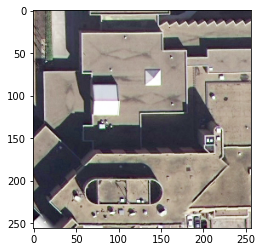

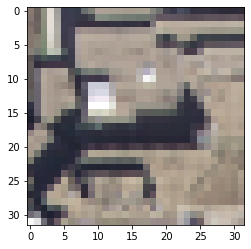

300 images were found.
The dimension of the output array is (300, 3073)
Lables dictionary: {1: 'buildings', 2: 'harbor', 3: 'agricultural'}


In [6]:
# load dataset
data_folder = os.path.join('data', 'UCMerced_LandUse', 'Images')
img_size = 32
landuse_array, labels_dict = data_loader(data_folder, img_size)

To use pandas functions on our dataset, we have to convert our dataset to a dataframe. Convert the data using [pd.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), and rename the label column to 'label'. The label column is at index img_size\*img_size\*3, since our pixel size is img_size\*img_size\*3, so our label is at column img_size\*img_size\*3+1 and python index begins at 0. Name the resulting dataframe 'landuse_df'. Have a look at your dataframe using the [sample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) and [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) function. How many rows and columns does the dataframe have? 

In [8]:
# Your code goes here

# Solution:
landuse_df = pd.DataFrame(landuse_array)
landuse_df = landuse_df.rename(columns={img_size*img_size*3: 'label'})
print(landuse_df.info())
print("There are {} entries and {} columns in the DataFrame."\
      .format(landuse_df.shape[0], landuse_df.shape[1]))
landuse_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 3073 entries, 0 to label
dtypes: float64(3073)
memory usage: 7.0 MB
None
There are 300 entries and 3073 columns in the DataFrame.


,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
60,164.0,158.0,136.0,119.0,117.0,94.0,134.0,137.0,116.0,154.0,...,23.0,26.0,22.0,10.0,21.0,22.0,71.0,70.0,67.0,1.0
253,111.0,116.0,106.0,119.0,125.0,117.0,115.0,121.0,117.0,65.0,...,43.0,66.0,64.0,43.0,64.0,64.0,42.0,61.0,62.0,2.0
27,12.0,37.0,26.0,33.0,48.0,35.0,116.0,113.0,102.0,134.0,...,125.0,114.0,82.0,117.0,117.0,91.0,153.0,151.0,131.0,1.0
168,114.0,106.0,115.0,107.0,100.0,109.0,113.0,106.0,115.0,111.0,...,118.0,111.0,121.0,120.0,112.0,119.0,124.0,118.0,125.0,3.0
72,144.0,149.0,129.0,51.0,67.0,45.0,26.0,42.0,32.0,28.0,...,126.0,125.0,109.0,109.0,106.0,93.0,108.0,106.0,93.0,1.0


### Numerical Data Description

Numerical data description is usually a good starting point to get an overview of the data and find outliers, such as faulty data entries. This includes looking at the location, scale and shape of the data. It can also include calculating Pearson's correlation coefficient and Kendall's tau between columns, and the skew and kurtosis of columns.

Use the [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) function to find the location and scale of each column.


In [9]:
# Your code goes here

# Solution:
landuse_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,108.913333,116.733333,110.240000,111.173333,118.903333,112.063333,113.173333,120.616667,113.540000,114.676667,...,117.170000,124.046667,116.356667,116.563333,123.856667,116.263333,115.543333,122.810000,115.000000,2.000000
std,55.059826,48.886828,44.626234,54.671441,48.337103,44.632644,56.142407,50.618083,46.531843,56.333445,...,53.514613,47.424834,44.273279,53.209179,46.589104,43.573802,51.515833,44.473064,41.522529,0.817861
min,2.000000,11.000000,9.000000,0.000000,7.000000,16.000000,0.000000,1.000000,14.000000,0.000000,...,0.000000,5.000000,14.000000,2.000000,10.000000,19.000000,3.000000,16.000000,19.000000,1.000000
25%,68.750000,75.000000,74.000000,72.000000,85.750000,80.000000,71.500000,82.000000,79.000000,74.750000,...,83.000000,90.750000,84.000000,81.750000,89.750000,85.750000,81.000000,88.750000,85.000000,1.000000
50%,114.500000,117.000000,110.000000,117.000000,121.000000,111.500000,115.500000,121.000000,113.000000,117.500000,...,120.000000,122.500000,117.000000,122.000000,124.000000,115.000000,120.000000,121.000000,114.000000,2.000000
75%,148.250000,154.250000,138.000000,147.250000,151.500000,137.000000,156.000000,159.000000,140.000000,153.250000,...,152.000000,158.250000,139.250000,154.000000,160.000000,142.000000,151.250000,155.000000,136.500000,3.000000
max,233.000000,242.000000,243.000000,255.000000,252.000000,255.000000,255.000000,241.000000,254.000000,255.000000,...,237.000000,238.000000,240.000000,236.000000,238.000000,240.000000,241.000000,236.000000,236.000000,3.000000


### Data Visualization

We can now look at different ways to visualize our data. We'll start with box plots and histograms, then go on to density plots and violin plots. Last, we'll look at the interaction between variables using a scatter plot.

Pandas dataframes come with a [boxplot function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html). Use it to plot a figure with boxplots for the first, 1000. and 3000. column of the dataframe. What do you see? 

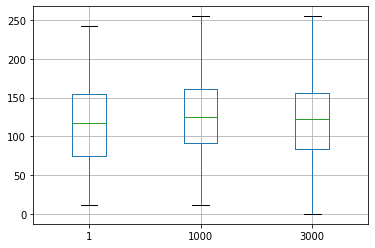

In [7]:
# Your code goes here

# Solution: 
# Box plot
landuse_df.boxplot([1,1000,3000])
plt.show()

Now, we want to plot a histogram of our data. Since it is image data, it can be split into the red, green and blue band of pixels. Write a function that plots one histogram each for the red, green and blue band of pixels. 

Hint: Each band has img_size\*img_size number of pixels. Thus, the first img_size\*img_size pixels are red, the second green and the third blue. 

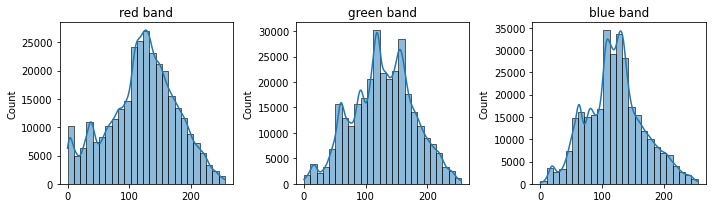

In [10]:
def histogram_band(dataframe):
    ''' Plots histograms of the dataframe split by color bands.
    Inputs: 
        dataframe: dataframe to be plotted.
    '''
    # Your code goes here
    raise NotImplementedError #this line can be deleted
    
#histogram_band(landuse_df)

# Solution: 
def histogram_band(dataframe):
    ''' Plots histograms of the dataframe split by color bands.
    Inputs: 
        dataframe: dataframe to be plotted.
    '''
    # Histogram: 
    img_pixels = img_size*img_size
    rr = list(range(0, dataframe.shape[1]-1, 3))
    bb = list(range(2, dataframe.shape[1]-1, 3))
    gg = list(range(1, dataframe.shape[1]-1, 3))
    bands = [rr, bb, gg]
    band_names = ['red', 'green', 'blue']
    # Your code goes here
    fig, ax = plt.subplots(1,3, figsize=(10,3))
    for ii, band in enumerate(bands):
        sns.histplot(dataframe[band].values.reshape(-1,), ax=ax[ii], kde=True, bins=25) # Reshape into 1D array
        ax[ii].set_title('{} band'.format(band_names[ii])) # Subplot titles
    fig.tight_layout()
    plt.show()
    
histogram_band(landuse_df)

We can now see, how all data points are distributed for each band. For example, most images seems to have a moderate amount of blue, while the distribution of red in the images is more broad. 

We can also split the histogram even further, into bands and labels. Implement a function, that plots one historgram for each band and label.

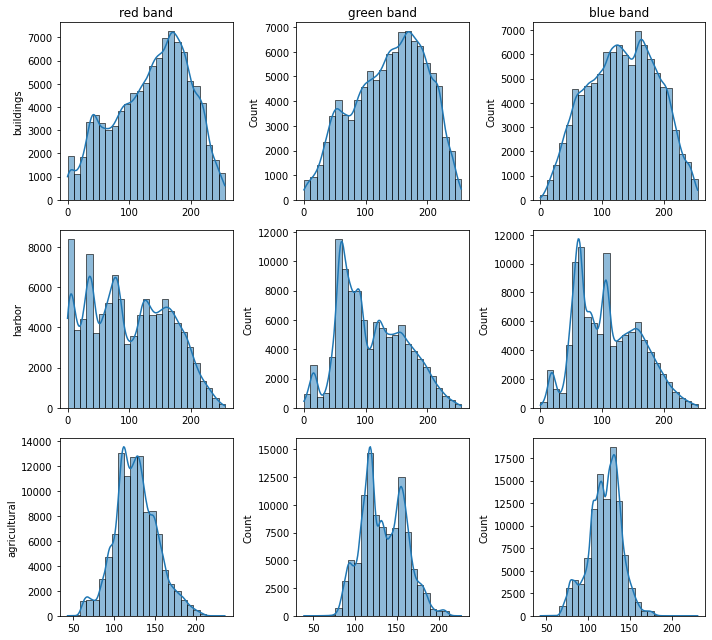

In [11]:
def histogram_band_label(dataframe):
    ''' Plots histograms of the dataframe split by color bands.
    Inputs: 
        dataframe: dataframe to be plotted.
    '''
    # Your code goes here
    raise NotImplementedError #this line can be deleted
    
#histogram_band_label(landuse_df)

# Solution
def histogram_band_label(dataframe):
    ''' Plots histograms of the dataframe split by color bands.
    Inputs: 
        dataframe: dataframe to be plotted.
    '''
    rr = list(range(0, dataframe.shape[1]-1, 3))
    bb = list(range(2, dataframe.shape[1]-1, 3))
    gg = list(range(1, dataframe.shape[1]-1, 3))
    bands = [rr, bb, gg]
    band_names = ['red', 'green', 'blue']
    labels = np.sort(landuse_df.label.unique()) # Get the labels in the dataset, by looking at possible values of "label" attribute
    fig, ax = plt.subplots(labels.size,3, figsize=(10,9))
    for ii, label in enumerate(labels):
        for jj, band in enumerate(bands):
            sns.histplot(landuse_df.loc[landuse_df['label']==label][band].values.reshape(-1,), \
                         ax=ax[ii][jj], kde=True, bins=25) # Filter by label
        [ax[0][ii].set_title('{} band'.format(band_names[ii]))] # Subplot titles
        #[ax[0][ii].set_title("Band {}".format(band)) for ii, band in enumerate(bands)] # Set band titles on top plots
        [ax[ii][0].set_ylabel("{}".format(labels_dict[label])) for ii, label in enumerate(labels)] # Set label titles in left-most plots
    fig.tight_layout()
    plt.show()
    
histogram_band_label(landuse_df)

What are some of the differences you now see between the different classes?

Another way to plot densities is to use [kernel-density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation). Kernel-density estimation is a non-parametric way to estimate the probability density function of a random variable given observations. The most common kernel is the Gaussian kernel, which is implemented in seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html). It fits multiple Gaussian distributions and sums these to estimate the final distribution. 

For each, create one plot using `sns.kdeplot` to plot the estimates density, separated for each class. 

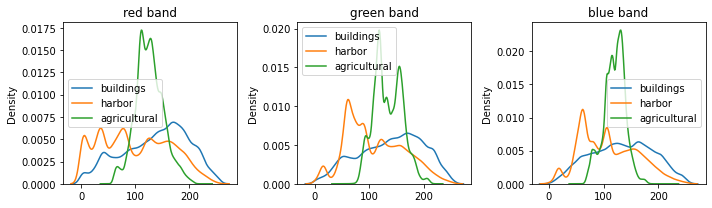

In [12]:
def kde_plot(dataframe):
    ''' Plots a kernel-density estimate for each label and band.
    Inputs:
        dataframe: the dataframe to be plotted.
    '''
    # Your code goes here 
    raise NotImplementedError #this line can be deleted

#kde_plot(landuse_df)

# Solution
def kde_plot(dataframe):
    ''' Plots a kernel-density estimate for each label and band.
    Inputs:
        dataframe: the dataframe to be plotted.
    '''
    rr = list(range(0, dataframe.shape[1]-1, 3))
    bb = list(range(1, dataframe.shape[1]-1, 3))
    gg = list(range(2, dataframe.shape[1]-1, 3))
    bands = [rr, bb, gg]
    band_names = ['red', 'green', 'blue']
    labels = np.sort(landuse_df.label.unique()) # Get the labels in the dataset, by looking at possible values of "label" attribute
    fig, ax = plt.subplots(1,3, figsize=(10,3))
    for ii, band in enumerate(bands):
        for label in labels:
            sns.kdeplot(landuse_df[landuse_df["label"]==label][band].values.reshape(-1,), \
                         ax=ax[ii], label=labels_dict[label])
        [ax[ii].set_title('{} band'.format(band_names[ii]))] # Subplot titles
        ax[ii].legend() # Put legend outside plot
    fig.tight_layout()
    plt.show()

kde_plot(landuse_df)

Now that we know kernel-densiyt estimation, we can use it to create a variation of our boxplots. Use seaborn's [`violinplot`](https://seaborn.pydata.org/generated/seaborn.violinplot.html) to create a violin plot for the same columns as you created a boxplot for. Look up violin plots to find out what each feature means.

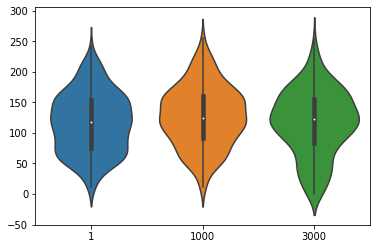

In [15]:
# Your code goes here

# Solution:
sns.violinplot(data=landuse_df[[1,1000,3000]])
plt.show()

To get a better feeling of the interaction between different columns, we can use pair plots. Using seaborn's [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html), create a pair plot between the first and second and the first and 1000. column of the dataframe. Can you explain what you see?

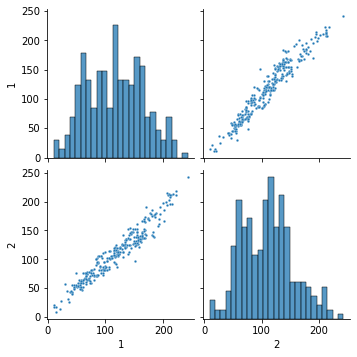

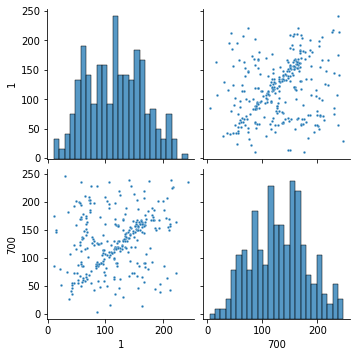

In [17]:
# Your code goes here

# Solution:
# Between first and second pixel:
sns.pairplot(landuse_df, vars = [1, 2], \
             plot_kws={'s' : 6}, diag_kws={'bins' : 25}) # Set variables of interest, marker size and bins for histograms
plt.show()

# Between first and 1000th pixel:
sns.pairplot(landuse_df, vars = [1, 700], \
             plot_kws={'s' : 6}, diag_kws={'bins' : 25}) # Set variables of interest, marker size and bins for histograms
plt.show()

### Linear Dimensionality Reduction

For linear dimensionality reduction, principal component analysis can be used. Run the cell below to define a plottin function for the components:

In [18]:
def plot_2D(transformed_data, labels):
    fig, ax = plt.subplots(1)
    for label in np.unique(labels):
        ix = np.where(labels == label)
        plt.scatter(transformed_data[ix, 0], transformed_data[ix, 1], label=labels_dict[label])
    ax.legend()
    ax.set_title('Two-dimensional data projection')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    plt.show()
    
labels = landuse_df['label']

Now, define a function to extract the principal components of a dataset. First, define your PCA object using [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) with `n_components` defined as the number of components that are given in your functions input (`num_comps`). The, use this pca object's function `fit_transform` to fit the model to your dataset and transform the data. Then use your function to plot the first two components of the dataset.

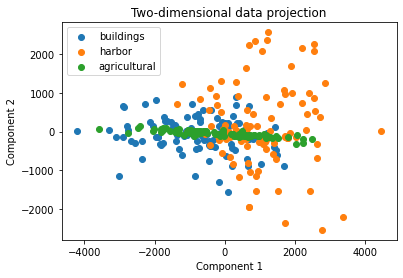

In [19]:
def pca(dataset, num_comps):
    ''' Extracts the principal components of a dataset.
    Inputs:
        dataset: dataframe or numpy array to be transformed.
        num_comps: number of components to be extracted.
    Returns:
        transformed_data: numpy array of the transformed dataset.
    '''
    # Your code goes here.
    raise NotImplementedError

#reduced_data = pca(landuse_df, 2)
#plot_2D(reduced_data, labels)

# Solution:
def pca(dataset, num_comps):
    ''' Extracts the principal components of a dataset.
    Inputs:
        dataset: dataframe or numpy array to be transformed.
        num_comps: number of components to be extracted.
    Returns:
        transformed_data: numpy array of the transformed dataset.
    '''
    pca = sklearn.decomposition.PCA(n_components=num_comps)
    transformed_data = pca.fit_transform(dataset)
    return transformed_data

reduced_data = pca(landuse_df, 2)
plot_2D(reduced_data, labels)

### Non-linear dimensionality reduction

As we can see, the first three principal components to not fully separate the datapoints of each class. Non-linear dimensionality reduction techniques can sometimes yield better result, at the cost of being harder to interpret. 

We will use Isomap and UMAP to illustrate non-linear dimensionality reduction. Isomap uses geodesic distance (the distance when 'hopping' from one datapoint to another using the datapoints in between). It specifically defines the geodesic distance to be the sum of edge weights along the shortest path between two nodes, when the datapoints are interpreted as a connected graph. The theory behind UMAP is quite involved, and is described in [this paper](https://arxiv.org/abs/1802.03426).

Use [`sklearn.manifold.Isomap`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html) to implement an Isomap transformation function similar to the pca transformation. Isomap has another hyperparamter, the number of neighbors (n_neighbors), that must be defined when defining the isomap object. Here, we just use 5. Plot the transformed data using the plotting function from before.

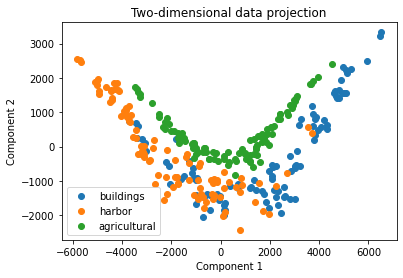

In [23]:
def isomap_transform(dataset, num_comps, num_neighbors=5):
    ''' Transforms the dataset onto two dimensions using isomap.
    Inputs:
        dataset: dataframe or numpy array to be transformed.
        num_comps: number of dimensions to be reduced to.
    Returns:
        transformed_data: numpy array of the transformed dataset.
    '''
    # Your code goes here.
    raise NotImplementedError

#reduced_data = isomap_transform(landuse_df, 2)
#plot_2D(reduced_data, labels)

# Solution:
def isomap_transform(dataset, num_comps, num_neighbors=5):
    embedding = sklearn.manifold.Isomap(n_components=num_comps, n_neighbors=num_neighbors)
    transformed_data = embedding.fit_transform(dataset)
    return transformed_data


reduced_data = isomap_transform(landuse_df, 2)
plot_2D(reduced_data, labels)

UMAP is implemented in its own package, called `umap`. Use the [`umap.UMAP`](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) function to transform the data, similar to bevore.


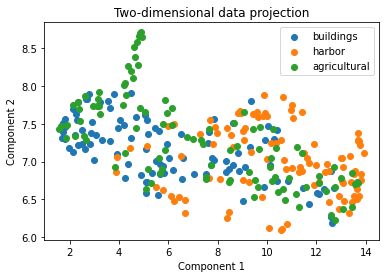

In [24]:
def umap_transform(dataset, num_comps):
    ''' Transforms the dataset onto two dimensions using UMAP.
    Inputs:
        dataset: dataframe or numpy array to be transformed.
        num_comps: number of dimensions to be reduced to.
    Returns:
        transformed_data: numpy array of the transformed dataset.
    '''
    # Your code goes here.
    raise NotImplementedError

#reduced_data = isomap_transform(landuse_df, 2)
#plot_2D(reduced_data, labels)

# Solution
def umap_transform(dataset, num_comps):
    ''' Transforms the dataset onto two dimensions using UMAP.
    Inputs:
        dataset: dataframe or numpy array to be transformed.
        num_comps: number of dimensions to be reduced to.
    Returns:
        transformed_data: numpy array of the transformed dataset.
    '''    
    embedding = umap.UMAP(n_components=num_comps)
    transformed_data = embedding.fit_transform(dataset)
    return transformed_data

random_seed = 15
np.random.seed(random_seed)
random.seed(random_seed)
reduced_data = umap_transform(landuse_df, 2)
plot_2D(reduced_data, labels)

UMAP does not seem to transform the data in a way that separated the labels. We can thus see, that the type of dimensionality reduction technique we use strongly depends on the dataset and not all techniques are suitable for every dataset.